## IMPORT MODULES AND DATA PROCESSING

In [21]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## IMPORT PACKAGES
import warnings
import numpy as np
import torch
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from data_processing.read_data import generate_MAPAL_data,generate_new_data
from annotator.Model import Annotator_1,Annotator_2
from classifier.Model import LR,PWC
from classifier.trainer import train_LR
from classifier.evaluation import eval_model,classf_eval_after_warmup,classf_eval_after_training, compare_true_label,print_scores,classifier_Val_scores_during_AL
from classifier.warmup import warmedup_classifiers
from annotator.warmup import annotator_warmup
from annotator.evaluation import eval_annotator_model,annot_eval_after_warmup, annot_eval_after_training,annotator_AL_loss
from AL_design.train_scheme import AL_train_cycle,AL_train_cycle_KB,AL_train_majority,AL_train_MAPAL_instances
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from stats.utils import diverse_samples
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.metrics import accuracy_score, f1_score
from stats.utils import Knowledge_Base_Metrics

if torch.cuda.is_available(): 
 device = "cuda:0" 
else: 
 device = "cpu" 


def set_seed(seed: int = 42) -> None:  ## Set SEEDS FUNCTION
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    # os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

Data_path = "/Users/kaizer/Documents/Active Learning/Code/MAAL/Multi-Annotator-HIL/data/medical.csv"
Dataset = "medical"


budget = 0.2
test_ratio = 0.4
boot_size = 0.05

parent_dir = "results/Knowledge_Base/"
dir = Dataset + "-"+str(budget)
seed = 1
set_seed(seed)

Path = os.path.join(parent_dir,dir)
if not os.path.isdir(Path):
    os.mkdir(Path)
print("Knowledge Base Results directory path : ",Path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Random seed set as 1
Knowledge Base Results directory path :  results/Knowledge_Base/medical-0.2


In [22]:
## RUN CELL TO GENERATE FRESH DATA
TRAIN, VAL, BOOT, ACTIVE, budget = generate_new_data(Data_path,test_ratio=test_ratio,boot_size = boot_size, seed = seed)
x_train, y_train, y_annot_train = TRAIN
x_val, y_val, y_annot_val = VAL
x_boot, y_boot, y_annot_boot = BOOT
x_active, y_active, y_annot_active = ACTIVE
m = y_annot_active.shape[1]

In [23]:
## RUN MAPAL
! python3 src/evaluation_scripts/experimental_setup.py \
  --query_strategy mapal-1-0.0001-2-1-entropy \
  --data_set medical \
  --results_path results/medical/csvs \
  --test_ratio 0.4 \
  --budget 0.2 \
  --seed 1

TYPE dataset :  <class 'pandas.core.frame.DataFrame'>
TYPE dataset :  <class 'pandas.core.frame.DataFrame'>
medical: (62, array([ 71, 216]), array([0.79790941, 0.83623693, 0.7804878 , 0.83972125, 0.85017422,
       0.71080139]))
seed: 1
bandwidth: 1.9718004515812175
prior = [0.0001 0.    ]
budget: 0
is_unlabeled type :  <class 'numpy.ndarray'>
is_unlabeled shape :  (172, 6)
unlabeled_indices shape :  (172,)
n_labels_per_annotator :  [0 0 0 0 0 0]
scores shape : (filled with nan ) (172, 6)
fit beta annotators model
(172, 62)
(172, 6)
estimate mean annotation performance
self bam prediction shape :  (6, 172, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
A_mean shape :  (172, 6)
mean annotation performance values: [1. 1. 1. 1. 1. 1.]
n_labels_per_annotator [0 0 0 0 0 0]
A shape :  (172, 2)
[1. 1.]
c :  [[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
Z shape :  (172, 2)
Z :  [0. 0.]
K_x shape : 

In [24]:
## RUN CELL TO USE MAPAL GENERATED DATA

TRAIN, VAL, BOOT, ACTIVE, instance_annotator_pair, Mapal_Data, ordered_instances, budget, MAPAL_results_path = generate_MAPAL_data(boot_size,seed)
x_train, y_train, y_annot_train = TRAIN
x_val, y_val, y_annot_val = VAL
x_boot, y_boot, y_annot_boot = BOOT
x_active, y_active, y_annot_active = ACTIVE
m = y_annot_active.shape[1]
new_x_train,new_y_train,new_y_annot_train = Mapal_Data
Mapal_Data_Frame = pd.read_csv(MAPAL_results_path)
Mapal_Data_Frame

Train features shape, Train labels shape, Train Annotator Labels shape
(172, 62) (172,) (172, 6)
Validation features Shape, Validation labels shape, Validation Annotators Label shape
(115, 62) (115,) (115, 6)
(172, 62) (172,) (172, 6)
boot up (array([0, 1]), array([2, 6])) 8
active up (array([0, 1]), array([ 47, 117]))
valid up (array([0, 1]), array([22, 93]))
Boot Data Features shape, Boot Data Labels shape, Boot Data Annotator Labels shape
(8, 62) (8,) (8, 6)
Active Data Features shape, Active Data Labels shape, Active Data Annotator Labels shape
(164, 62) (164,) (164, 6)
MAPAL budget :  206
Our Budget :  158


,index,train-micro-misclf-rate,test-micro-misclf-rate,train-macro-misclf-rate,test-macro-misclf-rate,n-labeled-samples,n-true-labels-0,n-false-labels-0,n-true-labels-1,n-false-labels-1,...,n-false-labels-2,n-true-labels-3,n-false-labels-3,n-true-labels-4,n-false-labels-4,n-true-labels-5,n-false-labels-5,n-true-labels,n-false-labels,times
0,0,0.436047,0.530435,0.474365,0.494379,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
1,1,0.284884,0.191304,0.500000,0.500000,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.017530
2,2,0.284884,0.191304,0.500000,0.500000,2,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0.014980
3,3,0.284884,0.191304,0.500000,0.500000,3,0,1,1,0,...,0,0,0,0,0,0,0,2,1,0.014595
4,4,0.284884,0.191304,0.500000,0.500000,4,0,1,1,0,...,0,1,0,0,0,0,0,3,1,0.014815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,0.174419,0.208696,0.207898,0.337243,144,44,8,18,2,...,11,30,7,28,7,11,11,156,46,0.014684
203,203,0.168605,0.191304,0.203833,0.326491,144,44,8,18,2,...,11,30,7,29,7,11,11,157,46,0.014856
204,204,0.168605,0.191304,0.203833,0.326491,144,44,8,18,2,...,11,30,7,29,7,12,11,158,46,0.015391
205,205,0.168605,0.191304,0.203833,0.326491,144,44,8,19,2,...,11,30,7,29,7,12,11,159,46,0.016150


In [38]:
labels, frequency = np.unique(y_val,return_counts=True)
print('Labels : ',labels)
print('Frequency : ',frequency)

Labels :  [0 1]
Frequency :  [22 93]


In [26]:
data_c_AM = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on Annotator Model Labels
data_c_KB = [{},{},{},{}]
data_c_WO = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on W Optimal Labels
data_c_AM_EE = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on Annotator Model Labels with Exploration-Exploitation
data_c_M = [{},{},{},{}]    ## Store Classifier Metrics corresponsind to classifier trained on Majority Labels
data_c_MAPAL = [{},{},{},{}] ## Store Classifier Metrics corresponsind to classifier trained on MAPAL selected instances 

data_a_AM = [{},{}] ## Store Annotator Metrics corresponsind to classifier trained on Annotator Model Labels
data_a_KB = [{},{}]
data_a_WO = [{},{}]  ## Store Annotator Metrics corresponsind to classifier trained on W Optimal Labels
data_a_AM_EE = [{},{}]  ## Store Annotator Metrics corresponsind to classifier trained on Annotator Model Labels with Exploration-Exploitation
data_a_M = [{},{}]     ## Store Annotator Metrics corresponsind to classifier trained on Majority Labels
data_a_MAPAL = [{},{}]  ## Store Classifier Metrics corresponsind to classifier trained on MAPAL selected instances 

classifier_model = LR(max_iter = 800)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    classifier_model.train(new_x_train,new_y_train)
y_LR_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Logistic Regression Classifier')
a,f = eval_model(y_val, y_LR_pred_val)
print("Accuracy::", a)
print("F1 score :: ", f)

classifier_model = PWC(2)
classifier_model.train(new_x_train,new_y_train)
y_PWC_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Parzen Window Classifier')
a,f = eval_model(y_val, y_PWC_pred_val)
print("Accuracy::", a)
print("F1 score :: ", f)

classifier_model = LR(max_iter=800)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    classifier_model.train(x_train,y_train)
y_LR_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING WITH Logistic Regression Classifier')
a,f = eval_model(y_val, y_LR_pred_val)
print("Accuracy::", a)
print("F1 score :: ", f)

classifier_model = PWC(2)
classifier_model.train(x_train,y_train)
y_PWC_pred_val = classifier_model.predict(x_val)
print('\n\nFULLY SUPERVISED LEARNING WITH Parzen Window Classifier')
a,f = eval_model(y_val, y_PWC_pred_val)
print("Accuracy::", a)
print("F1 score :: ", f)



FULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Logistic Regression Classifier
Accuracy:: 0.808695652173913
F1 score ::  0.8817204301075269


FULLY SUPERVISED LEARNING ON INSTANCES SELECTED BY MAPAL WITH Parzen Window Classifier
Accuracy:: 0.6869565217391305
F1 score ::  0.783132530120482


FULLY SUPERVISED LEARNING WITH Logistic Regression Classifier
Accuracy:: 0.8434782608695652
F1 score ::  0.90625


FULLY SUPERVISED LEARNING WITH Parzen Window Classifier
Accuracy:: 0.7565217391304347
F1 score ::  0.8390804597701149


## Knowledge Base

Biodegradation : n_epochs = 3000 , lr = 0.001 , budget = 0.2, MAPAL : 0.81, KB: 0.84
Medical : n_epochs = 2000, lr = 0.0001
Sonar : n_epochs : 3000, lr = 0.001, budget = 0.2, MAPAL : 0.60, KB : 0.64
Parkinson : n_epochs : 3000, lr = 0.001, budget = 0.2, MAPAL : 0.61, KB: 0.62
Parkinson : n_epochs : 2000, lr = 0.0001, budget = 0.4, MAPAL : 0.77, KB: 0.78, Annotator_3
Ionosphere : n_epochs : 2000, lr = 0.0001, budget = 0.2, class_max_iter : 800, MAPAL : 0.79, KB : 0.87
Ionosphere : n_epochs : 2000, lr = 0.0001, budget = 0.4, class_max_iter : 800, MAPAL : 0.80, KB : 0.89
kc2: n_epochs : 2000, lr = 0.001, budget = 0.2, MAPAL : 0.84.3, KB : 0.84.6, Annotator_3

TO DO LIST:

1. change similarity_threhold to 0.95 or 0.99
2. Try euclidean distance instead of cosine_similarity
3. Print class diversity in annotator KB
4. Number of extra instances due to similarity
5. Varying Budget among the Annotators
6. Search different Annotator Models used
7. Intelligently select Boot Data/ clustering /Kmeans, Wcss metric, decide no. of clusters
8. Increase size of boot data
9. Save Information
10. Selecting instances based on clusters instead of similarity threshold. ---DO LATER
11. Share Classifier results, Knowledge Base metrics, Similar Instances metrics on different datasets.

Random seed set as 1


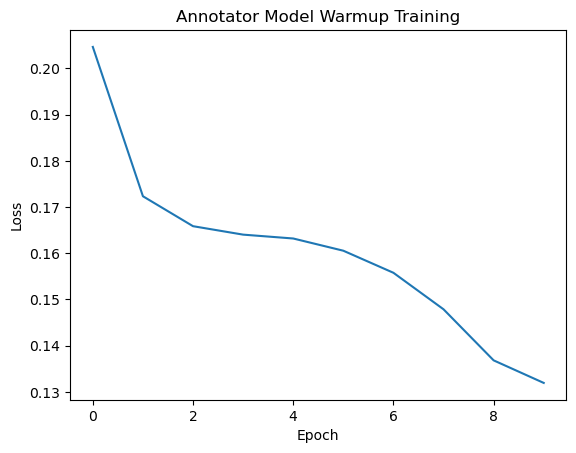

In [27]:
set_seed(1)
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]
annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 2000,learning_rate=0.0001,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_KB)

    ## assign seed on LR
    classifier_model_AM = LR(max_iter = 800)  ## Classifier to be trained on Annotator Model Labels
    classifier_model_WO = LR(max_iter = 800)  ## Classifier to be trained based on Optimal Weights
    classifier_model_M = LR(max_iter = 800)  ## Classifier to be trained on Majority Labels
    classifier_model_TL = LR(max_iter = 800) ## Classifier to be trained on True Labels of chosen instances
    # classifier_model_1 = PWC(2)
    # classifier_model_2 = PWC(2)
    # classifier_model_3 = PWC(2)
    # classifier_model_4 = PWC(2)
    Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
    Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

    classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_KB)

Knowledge_Base = dict()
index_frame = x_boot.index.values.tolist()
for index,data in zip(index_frame,x_boot.to_numpy()):
    data = torch.tensor(data,dtype=torch.float32)
    output = annotator_model(data)
    annot_index = torch.argmax(output,dim=0).item() ## CHECK WITH WEIGHT THRESHOLD ,Example 0.8 ETC
    if annot_index in Knowledge_Base:
        Knowledge_Base[annot_index]['index'].append(index)
        Knowledge_Base[annot_index]['label'].append(y_annot_boot.loc[index][annot_index])
    else:
        Knowledge_Base[annot_index] = dict()
        Knowledge_Base[annot_index]['index'] = [index]
        Knowledge_Base[annot_index]['label'] = [y_annot_boot.loc[index][annot_index]]

In [28]:
print('Knowledge_Base Composition after Warm-Up')
print(Knowledge_Base)

Knowledge_Base Composition after Warm-Up
{1: {'index': [61, 54, 121, 100], 'label': [0, 1, 1, 1]}, 4: {'index': [283, 269, 238, 274], 'label': [0, 1, 1, 1]}}


In [29]:
batch_size = 4
Classifiers, annotator_model,idx,collected_active_data,similar_instances,loss, inst_annot,full, c_a, c_f = AL_train_cycle_KB(Classifiers,Classifiers_y_boot,annotator_model,Knowledge_Base,TRAIN.copy(),BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = 2000, learning_rate = 0.0001,scheme = 1,RL_flag = 0, ee_ratio = 0,similarity_threshold = 0.9,weight_threshold = 0.7, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

Progress Bar : 100%|██████████| 158/158 [00:21<00:00,  7.25it/s]


In [39]:
print('Total number of Acive Learning Instances : ',new_active_x.shape[0])

Total number of Acive Learning Instances :  96


In [31]:
Knowledge_Base_Metrics(Knowledge_Base,similar_instances,new_active_y_true,Path)


KNOWLEDGE BASE METRIC

Size of Annotator Knowledge Base  1  :  27
Accuracy Score of Annotator Knowledge Base  1  :  0.8518518518518519
F1 Score of Annotator Knowledge Base  1  :  0.8749999999999999

Size of Annotator Knowledge Base  2  :  7
Accuracy Score of Annotator Knowledge Base  2  :  0.7142857142857143
F1 Score of Annotator Knowledge Base  2  :  0.8

Size of Annotator Knowledge Base  3  :  4
Accuracy Score of Annotator Knowledge Base  3  :  1.0
F1 Score of Annotator Knowledge Base  3  :  1.0

Size of Annotator Knowledge Base  4  :  39
Accuracy Score of Annotator Knowledge Base  4  :  0.717948717948718
F1 Score of Annotator Knowledge Base  4  :  0.8070175438596492

Size of Annotator Knowledge Base  5  :  1
Accuracy Score of Annotator Knowledge Base  5  :  1.0
F1 Score of Annotator Knowledge Base  5  :  1.0

Size of Annotator Knowledge Base  6  :  1
Accuracy Score of Annotator Knowledge Base  6  :  1.0
F1 Score of Annotator Knowledge Base  6  :  0.0


SIMILAR INSTANCES METRIC

Num

ON TRAINING DATA 
ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.7916666666666666

F1 Score :  0.8571428571428571

Confusion Matrix
[[16 11]
 [ 9 60]]

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.59      0.62        27
           1       0.85      0.87      0.86        69

    accuracy                           0.79        96
   macro avg       0.74      0.73      0.74        96
weighted avg       0.79      0.79      0.79        96



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.8854166666666666

F1 Score :  0.9197080291970803

Confusion Matrix
[[22  8]
 [ 3 63]]

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.73      0.80        30
           1       0.89      0.95      0.92        66

    accuracy                           0.89        96
   macro avg       0.88      0.84      0.86        96
weighted avg       0.89      0.89      0.88        96

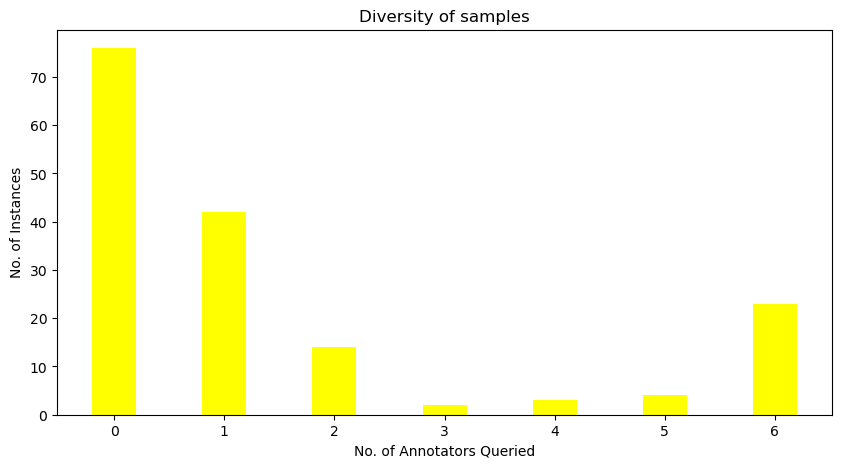

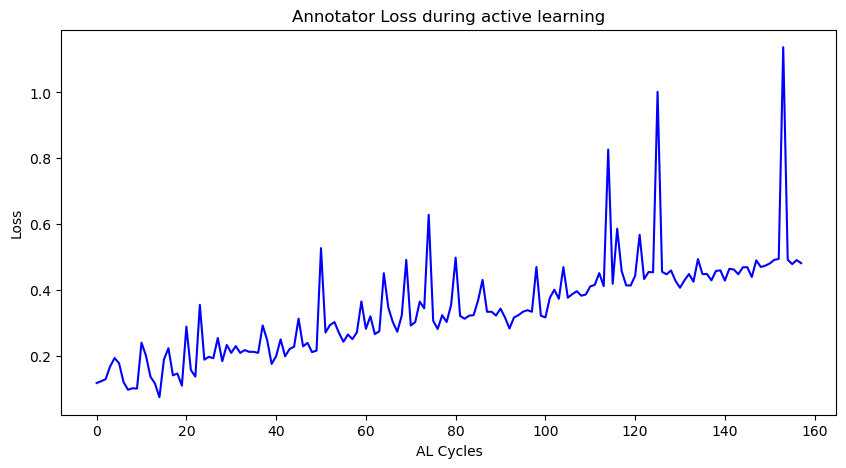

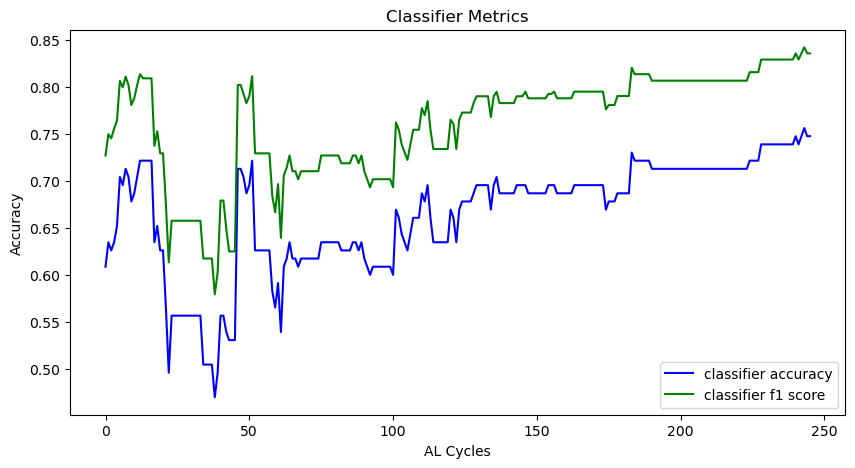

In [32]:
print('ON TRAINING DATA ')

compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full,Path)

annotator_AL_loss(loss,Path)

classifier_Val_scores_during_AL(c_a,c_f,Path)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_KB)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_KB)

In [33]:
df_c_KB = pd.DataFrame(data_c_KB,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_KB

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.75,0.833333,0.660870,0.774566,0.747826,0.836158
W Optimal,1.00,1.000000,0.800000,0.880829,0.747826,0.837989
Majority,0.75,0.800000,0.547826,0.653333,0.747826,0.834286
True Labels,1.00,1.000000,0.800000,0.880829,0.808696,0.884211


In [34]:
df_a_KB = pd.DataFrame(data_a_KB,index=['Weighted Average','Maximum Index'])
df_a_KB

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.875,0.923077,0.78125,0.848921
Maximum Index,0.750,0.833333,0.84375,0.890511


In [35]:
path1 = os.path.join(Path,"Classifier_Metrics.csv")
path2 = os.path.join(Path,"Annotator_Metrics.csv")
df_c_KB.to_csv(path1)
df_a_KB.to_csv(path2)

1. Knowledge Base  - compare annotator label with ground truth....for each annotator and then average 
2. Compare Labels based on similarity metrics --- compare ground truth with label obtained from Knowledge Base for a new incoming instance 
3. label from Instance and not the Annotator list
4. USE MAP instead of DICTIONARY....make class of Knowledge Base....Annotator,instances in Annotator and its label from that annotator, make list of all instances which matched an instance in knowledge base

## OPTION 1 --- LABELS FROM ANNOTATOR MODEL ( SCHEME 1 )

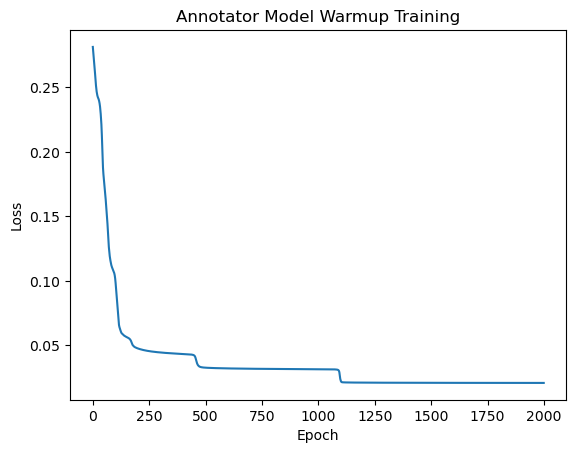

In [36]:
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]
# torch.manual_seed(seed)
annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 2000,learning_rate=0.0001,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_AM)

    ## assign seed on LR
    classifier_model_AM = LR(max_iter = 2000)  ## Classifier to be trained on Annotator Model Labels
    classifier_model_WO = LR(max_iter = 2000)  ## Classifier to be trained based on Optimal Weights
    classifier_model_M = LR(max_iter = 2000)  ## Classifier to be trained on Majority Labels
    classifier_model_TL = LR(max_iter = 2000) ## Classifier to be trained on True Labels of chosen instances
    # classifier_model_1 = PWC(2)
    # classifier_model_2 = PWC(2)
    # classifier_model_3 = PWC(2)
    # classifier_model_4 = PWC(2)
    Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
    Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

    classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_AM)

In [37]:
batch_size = 4
Classifiers, annotator_model,idx,collected_active_data,loss, inst_annot,full, c_a, c_f = AL_train_cycle(Classifiers,Classifiers_y_boot,annotator_model,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = 1000, learning_rate = 0.0001,scheme = 1,RL_flag = 0, ee_ratio = 0, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

  7%|▋         | 11/158 [00:05<01:17,  1.89it/s]


KeyboardInterrupt: 

ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.9027777777777778

F1 Score :  0.8923076923076922

Confusion Matrix
[[36  6]
 [ 1 29]]

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        42
           1       0.83      0.97      0.89        30

    accuracy                           0.90        72
   macro avg       0.90      0.91      0.90        72
weighted avg       0.91      0.90      0.90        72



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.8472222222222222

F1 Score :  0.8253968253968255

Confusion Matrix
[[35  9]
 [ 2 26]]

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.80      0.86        44
           1       0.74      0.93      0.83        28

    accuracy                           0.85        72
   macro avg       0.84      0.86      0.84        72
weighted avg       0.87      0.85      0.85        72



MAJORITY LABEL

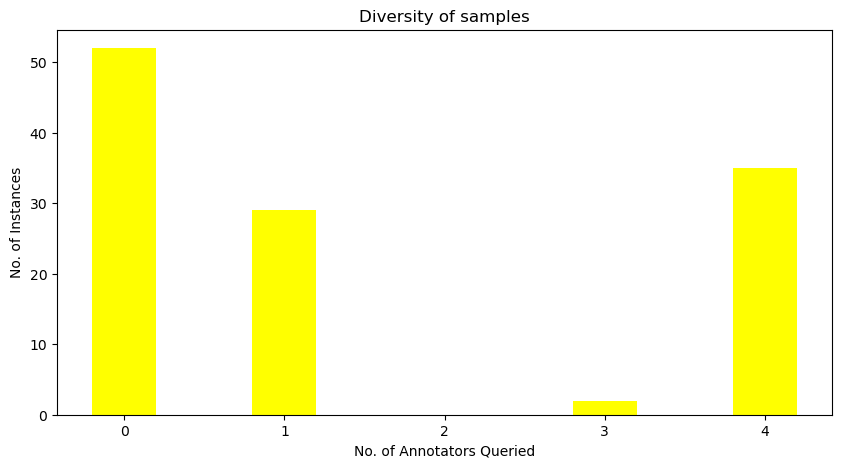

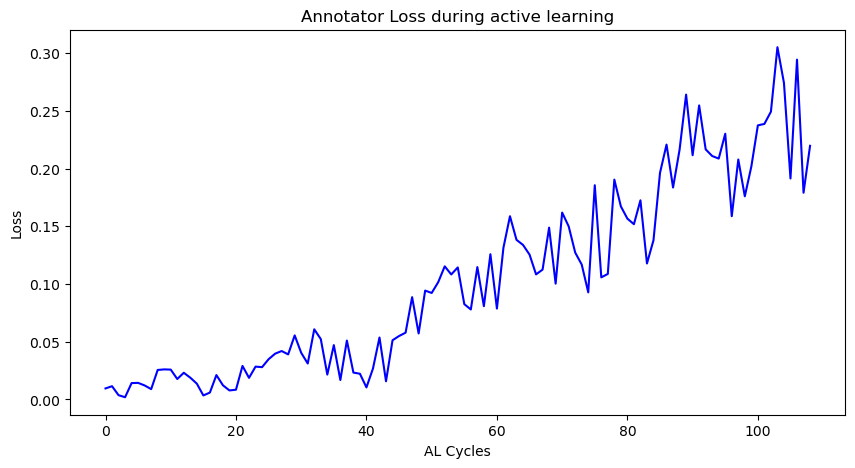

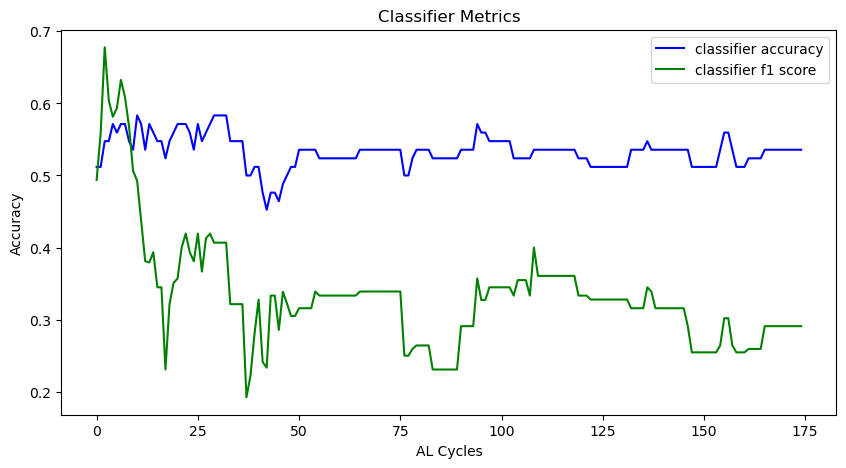

In [ ]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full)

fig = plt.figure(figsize = (10, 5))
plt.plot(loss, color ='blue')
plt.xlabel("AL Cycles") 
plt.ylabel("Loss")
plt.title("Annotator Loss during active learning")
plt.show()


fig = plt.figure(figsize = (10, 5))
plt.plot(c_a, color ='blue',label='classifier accuracy')
plt.plot(c_f, color ='green',label='classifier f1 score')
plt.legend()
plt.xlabel("AL Cycles")
plt.ylabel("Accuracy")
plt.title("Classifier Metrics")
plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_AM)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_AM)

CLASSIFIER METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [ ]:
df_c_AM = pd.DataFrame(data_c_AM,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_AM

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.666667,0.75,0.559524,0.694215,0.535714,0.290909
W Optimal,0.666667,0.75,0.559524,0.694215,0.523810,0.259259
Majority,0.666667,0.75,0.559524,0.694215,0.547619,0.240000
True Labels,1.000000,1.00,0.547619,0.457143,0.690476,0.638889


ANNOTATOR METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [ ]:
df_a_AM = pd.DataFrame(data_a_AM,index=['Weighted Average','Maximum Index'])
df_a_AM

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.833333,0.857143,0.819444,0.786885
Maximum Index,0.833333,0.857143,0.847222,0.825397


## OPTION 2 --- LABELS CHOSEN USING W OPTIMAL ( SCHEME 2 )

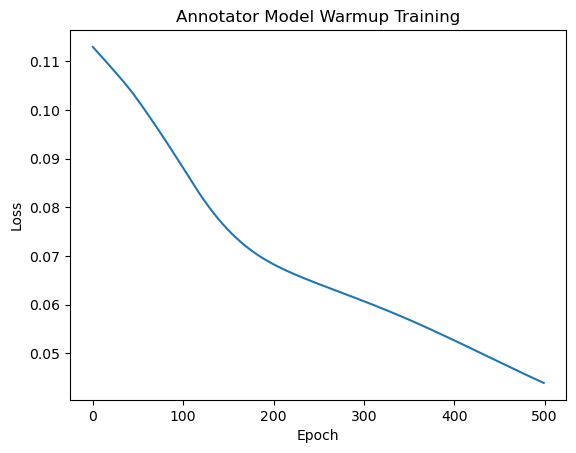

In [ ]:
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]

annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 500,learning_rate=0.0001,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_WO)

classifier_model_AM = LR(max_iter = 2000)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = 2000)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = 2000)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = 2000) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(2)
# classifier_model_2 = PWC(2)
# classifier_model_3 = PWC(2)
# classifier_model_4 = PWC(2)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_WO)

In [ ]:
batch_size = 4
Classifiers, annotator_model,idx,collected_active_data,loss, inst_annot,full, c_a, c_f = AL_train_cycle(Classifiers,Classifiers_y_boot,annotator_model,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = 100, learning_rate = 0.0001,scheme = 2,RL_flag = 0, ee_ratio = 0, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 175/175 [00:47<00:00,  3.68it/s]


ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.810126582278481

F1 Score :  0.810126582278481

Confusion Matrix
[[32  7]
 [ 8 32]]

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        39
           1       0.82      0.80      0.81        40

    accuracy                           0.81        79
   macro avg       0.81      0.81      0.81        79
weighted avg       0.81      0.81      0.81        79



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.8734177215189873

F1 Score :  0.875

Confusion Matrix
[[34  4]
 [ 6 35]]

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        38
           1       0.90      0.85      0.88        41

    accuracy                           0.87        79
   macro avg       0.87      0.87      0.87        79
weighted avg       0.87      0.87      0.87        79



MAJORITY LABELS VS TRUE LABEL

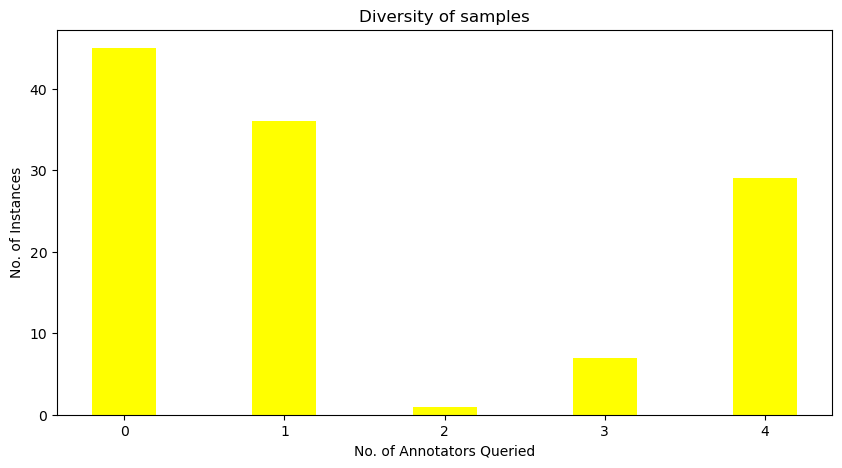

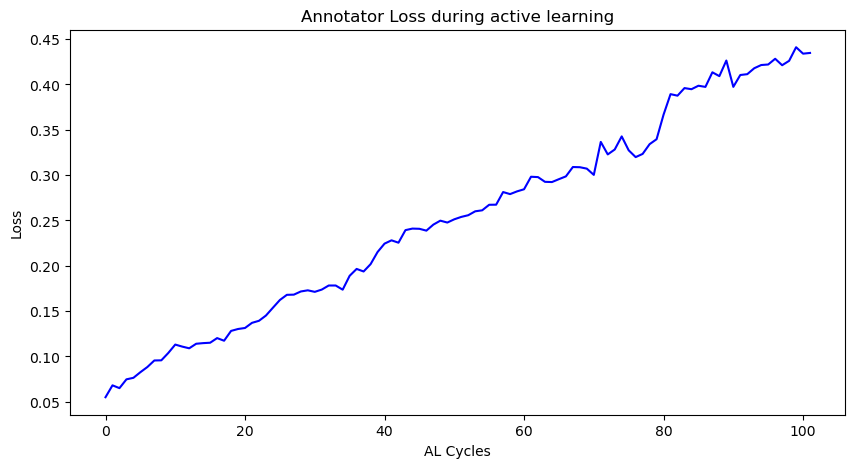

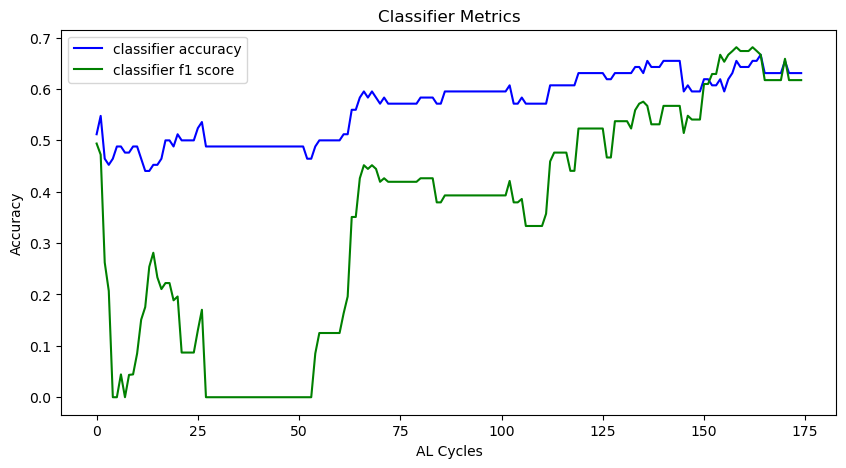

In [ ]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full)

fig = plt.figure(figsize = (10, 5))
plt.plot(loss, color ='blue')
plt.xlabel("AL Cycles")
plt.ylabel("Loss")
plt.title("Annotator Loss during active learning")
plt.show()

fig = plt.figure(figsize = (10, 5))
plt.plot(c_a, color ='blue',label='classifier accuracy')
plt.plot(c_f, color ='green',label='classifier f1 score')
plt.legend()
plt.xlabel("AL Cycles")
plt.ylabel("Accuracy")
plt.title("Classifier Metrics")
plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_WO)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_WO)

CLASSIFIER METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [ ]:
df_c_WO = pd.DataFrame(data_c_WO,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_WO

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.666667,0.75,0.559524,0.694215,0.583333,0.588235
W Optimal,0.666667,0.75,0.559524,0.694215,0.630952,0.617284
Majority,0.666667,0.75,0.559524,0.694215,0.666667,0.611111
True Labels,1.000000,1.00,0.547619,0.457143,0.690476,0.638889


ANNOTATOR METRICS AFTER ACTIVE LEARNING TRAINING CYCLE

In [ ]:
df_a_WO = pd.DataFrame(data_a_WO,index=['Weighted Average','Maximum Index'])
df_a_WO

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.666667,0.666667,0.797468,0.794872
Maximum Index,0.833333,0.857143,0.810127,0.805195


## OPTION 3 --- EXPLORATION EXPLOITATION USING LABELS FROM ANNOTATOR MODEL ( SCHEME 1 )

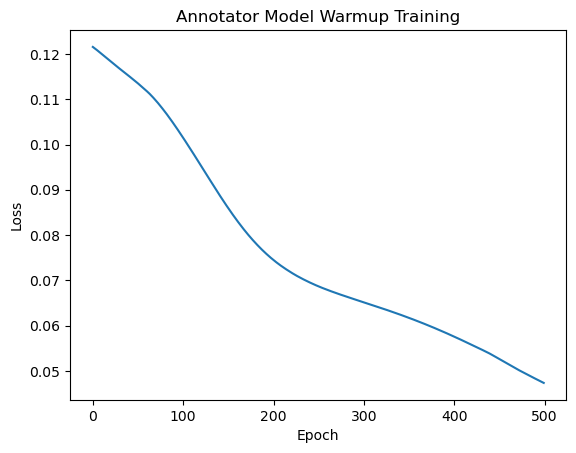

In [ ]:
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]

annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 500,learning_rate=0.0001,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_AM_EE)

classifier_model_AM = LR(max_iter = 800)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = 800)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = 800)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = 800) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(2)
# classifier_model_2 = PWC(2)
# classifier_model_3 = PWC(2)
# classifier_model_4 = PWC(2)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_AM_EE)

In [ ]:
batch_size = 4
Classifiers, annotator_model,idx,collected_active_data,loss, inst_annot,full, c_a, c_f = AL_train_cycle(Classifiers,Classifiers_y_boot,annotator_model,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = 100, learning_rate = 0.01,scheme = 1,RL_flag = 1, ee_ratio = 0.7, device = device) 
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 175/175 [00:39<00:00,  4.46it/s]


ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.9122807017543859

F1 Score :  0.9090909090909091

Confusion Matrix
[[27  2]
 [ 3 25]]

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        29
           1       0.93      0.89      0.91        28

    accuracy                           0.91        57
   macro avg       0.91      0.91      0.91        57
weighted avg       0.91      0.91      0.91        57



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.8771929824561403

F1 Score :  0.8679245283018868

Confusion Matrix
[[27  4]
 [ 3 23]]

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        31
           1       0.85      0.88      0.87        26

    accuracy                           0.88        57
   macro avg       0.88      0.88      0.88        57
weighted avg       0.88      0.88      0.88        57



MAJORITY LABEL

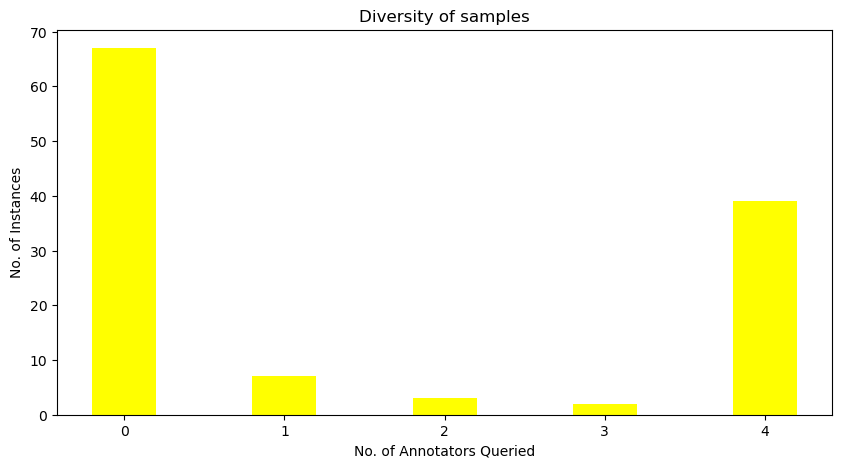

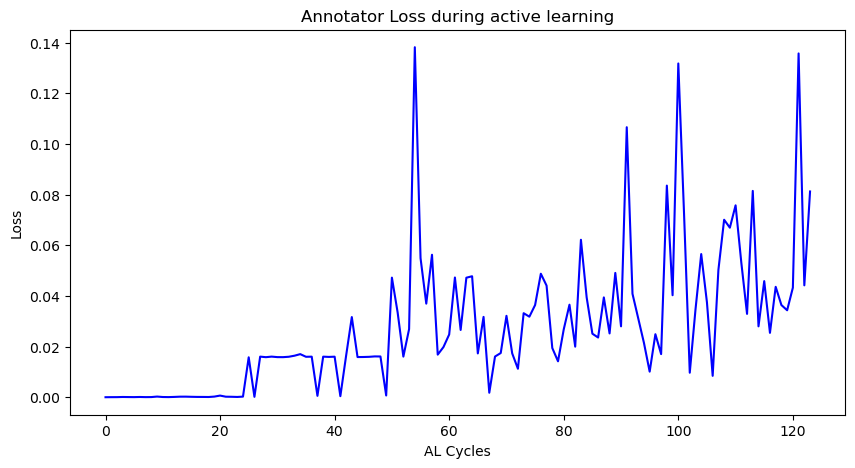

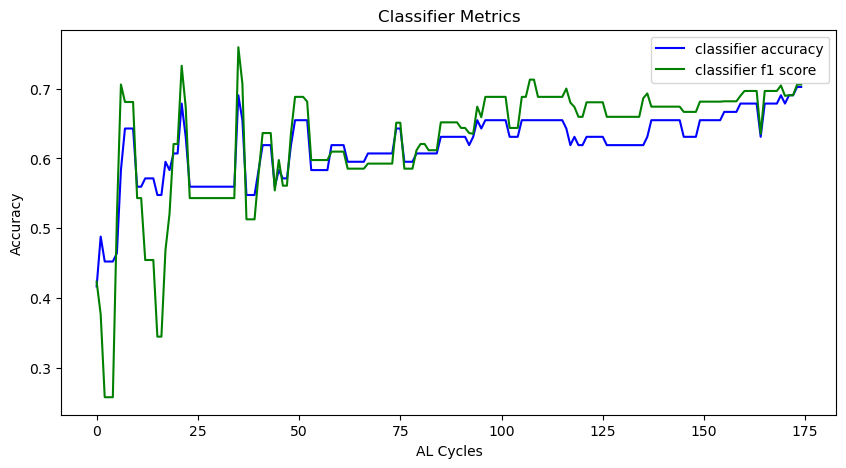

In [ ]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full)

fig = plt.figure(figsize = (10, 5))
plt.plot(loss, color ='blue')
plt.xlabel("AL Cycles")
plt.ylabel("Loss")
plt.title("Annotator Loss during active learning")
plt.show()

fig = plt.figure(figsize = (10, 5))
plt.plot(c_a, color ='blue',label='classifier accuracy')
plt.plot(c_f, color ='green',label='classifier f1 score')
plt.legend()
plt.xlabel("AL Cycles")
plt.ylabel("Accuracy")
plt.title("Classifier Metrics")
plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_AM_EE)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_AM_EE)

CLASSIFIER METRICS AFTER ACTIVE LEARNING TRAINING CYCLE WITH EXPLOITATION EXPLORATION RATIO

In [ ]:
df_c_AM_EE = pd.DataFrame(data_c_AM_EE,index = ['Annotator Model', 'W Optimal', 'Majority','True Labels'])
df_c_AM_EE

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Annotator Model,0.666667,0.75,0.559524,0.694215,0.702381,0.705882
W Optimal,0.666667,0.75,0.559524,0.694215,0.630952,0.607595
Majority,0.666667,0.75,0.559524,0.694215,0.619048,0.529412
True Labels,1.000000,1.00,0.547619,0.457143,0.714286,0.727273


ANNOTATOR METRICS AFTER ACTIVE LEARNING TRAINING CYCLE WITH EXPLOITATION EXPLORATION RATIO 

In [ ]:
df_a_AM_EE = pd.DataFrame(data_a_AM_EE,index=['Weighted Average','Maximum Index'])
df_a_AM_EE

,Annotator Accuracy after Warmup on Boot Data,Annotator F1 Score after Warmup on Boot Data,Annotator Accuracy after Training,Annotator F1 Score after Training
Weighted Average,0.666667,0.666667,0.894737,0.884615
Maximum Index,0.833333,0.857143,0.894737,0.884615


In [ ]:
from sklearn.metrics import accuracy_score
y_ones = np.ones_like(y_val)
accuracy_score(y_val,y_ones)

0.5

## OPTION 4 --- MAJORITY LABELS

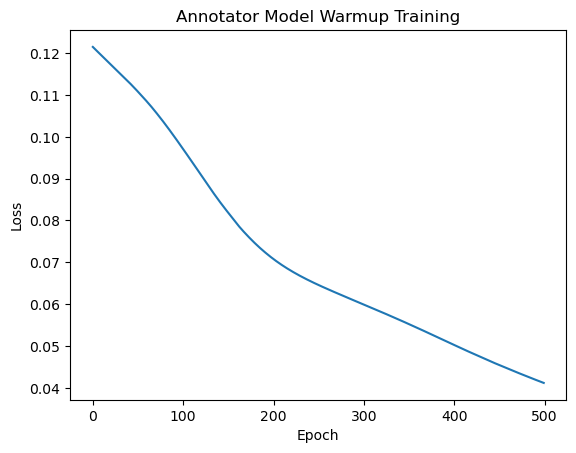

In [ ]:
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]

annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 500,learning_rate=0.0001,device = 'cpu')
    annot_eval_after_warmup(annotator_model, BOOT, data_a_M)
    
classifier_model_AM = LR(max_iter = 800)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = 800)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = 800)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = 800) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(2)
# classifier_model_2 = PWC(2)
# classifier_model_3 = PWC(2)
# classifier_model_4 = PWC(2)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_M)

In [ ]:
batch_size = 4
Classifiers,idx,collected_data,loss, inst_annot,full, c_a, c_f = AL_train_majority(Classifiers,Classifiers_y_boot,BOOT.copy(),ACTIVE.copy(),VAL.copy(),W_optimal,budget, batch_size,\
         n_epochs = 100, learning_rate = 0.00001, device = device)
new_active_x,new_active_y_true,new_active_y_annot,new_active_y,new_active_y_opt,new_active_y_majority,new_active_w,new_active_mask = collected_data
## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 175/175 [00:01<00:00, 133.14it/s]


ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.8472222222222222

F1 Score :  0.8307692307692308

Confusion Matrix
[[34  6]
 [ 5 27]]

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.82      0.84      0.83        32

    accuracy                           0.85        72
   macro avg       0.84      0.85      0.85        72
weighted avg       0.85      0.85      0.85        72



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.8333333333333334

F1 Score :  0.823529411764706

Confusion Matrix
[[32  5]
 [ 7 28]]

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.85      0.80      0.82        35

    accuracy                           0.83        72
   macro avg       0.83      0.83      0.83        72
weighted avg       0.83      0.83      0.83        72



MAJORITY LABELS

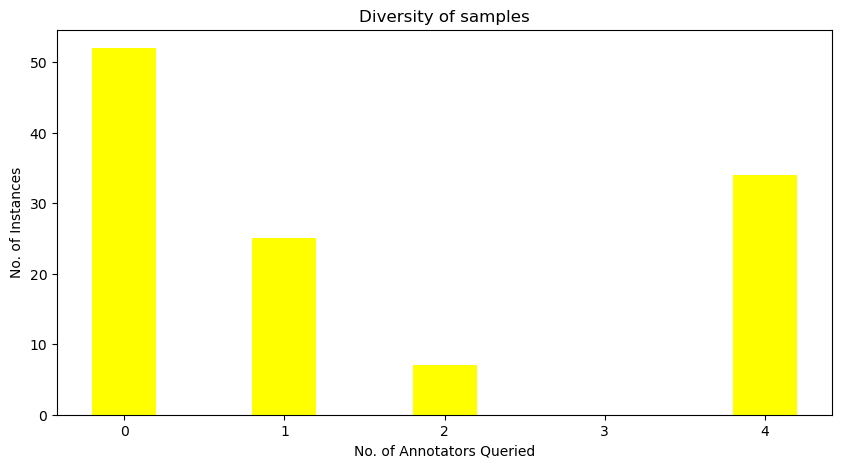

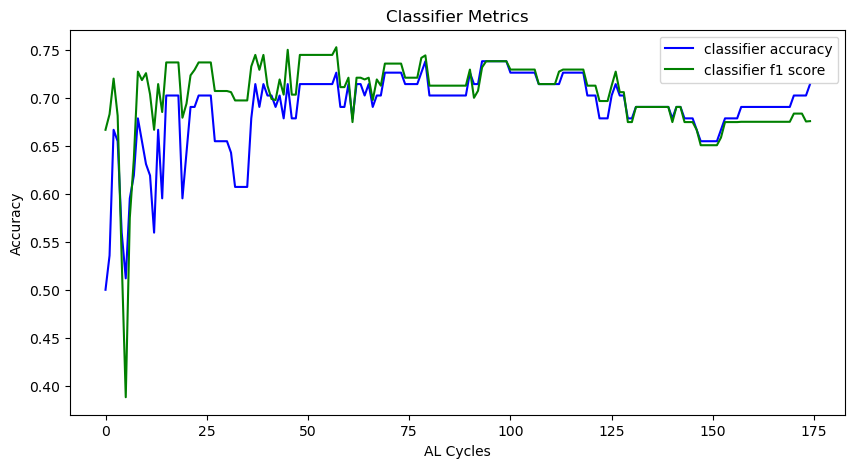

In [ ]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

diverse_samples(inst_annot,full)

fig = plt.figure(figsize = (10, 5))
plt.plot(c_a, color ='blue',label='classifier accuracy')
plt.plot(c_f, color ='green',label='classifier f1 score')
plt.legend()
plt.xlabel("AL Cycles")
plt.ylabel("Accuracy")
plt.title("Classifier Metrics")
plt.show()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annot_eval_after_training(annotator_model,new_active_x,new_active_y_true,new_active_y_annot,new_active_mask,data_a_M)
    classf_eval_after_training(Classifiers,new_active_x,new_active_y_opt,new_active_y_majority,new_active_y_true,VAL.copy(),data_c_M)

CLASSIFIER METRICS AFTER ACTIVE LEARNING CYCLE

In [ ]:
df_c_M = pd.DataFrame(data_c_M[2:],index = ['Majority','True Labels'])
df_c_M

,After Warmup Accuracy on Boot Data,After Warmup F1 Score on Boot Data,After Warmup Accuracy on Validation Data,After Warmup F1 Score on Validation Data,After Training Accuracy on Validation Data,After Training F1 Score on Validation Data
Majority,0.666667,0.75,0.559524,0.694215,0.714286,0.675676
True Labels,1.000000,1.00,0.547619,0.457143,0.738095,0.738095


## OPTION 5 --- TRAIN ON INSTANCES FROM MAPAL

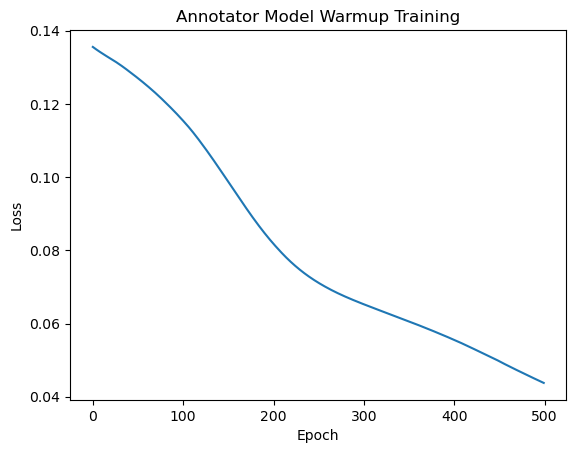

In [ ]:
input_dim = x_boot.shape[1]
H_dim = 32
output_dim = y_annot_boot.shape[1]

annotator_model = Annotator_2(input_dim,H_dim,output_dim)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    annotator_model, W_optimal,loss_list = annotator_warmup(annotator_model,x_boot, y_annot_boot,n_epochs = 500,learning_rate=0.0001,device = device)
    annot_eval_after_warmup(annotator_model, BOOT, data_a_MAPAL)

classifier_model_AM = LR(max_iter = 2000)  ## Classifier to be trained on Annotator Model Labels
classifier_model_WO = LR(max_iter = 2000)  ## Classifier to be trained based on Optimal Weights
classifier_model_M = LR(max_iter = 2000)  ## Classifier to be trained on Majority Labels
classifier_model_TL = LR(max_iter = 2000) ## Classifier to be trained on True Labels of chosen instances
# classifier_model_1 = PWC(2)
# classifier_model_2 = PWC(2)
# classifier_model_3 = PWC(2)
# classifier_model_4 = PWC(2)
Classifiers = [classifier_model_AM,classifier_model_WO,classifier_model_M, classifier_model_TL]
Classifiers,Classifiers_y_boot = warmedup_classifiers(Classifiers,BOOT,annotator_model,W_optimal)

classf_eval_after_warmup(Classifiers,BOOT,VAL,data_c_MAPAL)

In [ ]:
batch_size = 4
Classifiers, annotator_model,collected_active_data, loss, inst_annot, full, c_a,c_f = AL_train_MAPAL_instances(Classifiers,Classifiers_y_boot,annotator_model,ordered_instances,BOOT.copy(),ACTIVE.copy(),VAL.copy(),Mapal_Data,W_optimal,budget, batch_size,\
         n_epochs = 100, learning_rate = 0.00001, device = device)
new_active_x,new_active_y,new_active_y_opt,new_active_y_majority, new_active_y_true,new_active_y_annot, new_active_mask = collected_active_data

## DESCRIPTION

# new_active_x : Selected Instance Features
# new_active_y : Labels from annotator Model for selected Instances
# new_active_y_true : True Labels for all selected Instances
# new_active_y_opt : Labels corresponding to W Optimal for selected Instances
# new_active_y_majority : Labels corresponsing to Majority for selected Instances
# new_active_w : Optimal Weights calculated using Linear Programming for selected Instances
# new_active_mask : Annotators Queried for selected Instances
# new_active_y_annot : All Annotator Labels for selected Instances

100%|██████████| 199/199 [01:20<00:00,  2.47it/s] 


In [ ]:
compare_true_label(new_active_y,new_active_y_opt,new_active_y_majority,new_active_y_true)

ANNOTATOR MODEL PREDICTED LABELS VS TRUE LABELS

Accuracy :  0.8467741935483871

F1 Score :  0.831858407079646

Confusion Matrix
[[58 11]
 [ 8 47]]

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        69
           1       0.81      0.85      0.83        55

    accuracy                           0.85       124
   macro avg       0.84      0.85      0.85       124
weighted avg       0.85      0.85      0.85       124



W OPTIMAL LABELS VS TRUE LABELS

Accuracy :  0.8387096774193549

F1 Score :  0.8181818181818181

Confusion Matrix
[[59 13]
 [ 7 45]]

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.82      0.86        72
           1       0.78      0.87      0.82        52

    accuracy                           0.84       124
   macro avg       0.83      0.84      0.84       124
weighted avg       0.84      0.84      0.84       124



MAJORITY LABELS

In [ ]:
print((new_active_y_majority==new_active_y_opt).sum())
print((new_active_y==new_active_y_opt).sum())
print((new_active_y==new_active_y_majority).sum())

0    122
dtype: int64
0    121
dtype: int64
0    119
dtype: int64


In [ ]:
print('USING MAPAL SELECTED INSTANCES')
print_scores(Classifiers,VAL)

USING MAPAL SELECTED INSTANCES

Labels from Annotator Model
Accuracy :  0.6547619047619048
F1 Score :  0.5671641791044777
[[36 23]
 [ 6 19]]
              precision    recall  f1-score   support

           0       0.86      0.61      0.71        59
           1       0.45      0.76      0.57        25

    accuracy                           0.65        84
   macro avg       0.65      0.69      0.64        84
weighted avg       0.74      0.65      0.67        84


Labels from W optimal
Accuracy :  0.6666666666666666
F1 Score :  0.5333333333333333
[[40 26]
 [ 2 16]]
              precision    recall  f1-score   support

           0       0.95      0.61      0.74        66
           1       0.38      0.89      0.53        18

    accuracy                           0.67        84
   macro avg       0.67      0.75      0.64        84
weighted avg       0.83      0.67      0.70        84


Labels from Majority
Accuracy :  0.6309523809523809
F1 Score :  0.4745762711864407
[[39 28]
 [ 3 14]

[1, 2, 3, 4] [62, 31, 25, 0]


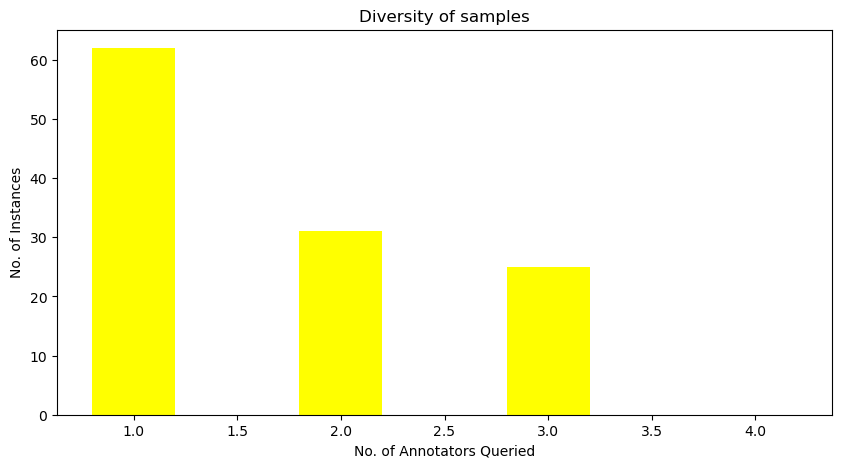

In [ ]:
diverse_samples(inst_annot,full)

During BOOT we have all annotations -- train Annotator Model

Create Knowledge Base for each annotator. Instances providing Weights above threshold will be collected in the Knowledge base of that particular annotator.

SET SEEDS AT ALL PLACES SUCH AS TORCH, NUMPY ETC. RUN MULTIPLE TIMES AND CHECK
CLEAN CODE 
SET SEEDS AT ALL PLACES SUCH AS TORCH, NUMPY ETC. RUN MULTIPLE TIMES AND CHECK
SHARE RESULTS WITH ENTROPY BASED
ACCURACY OF TRAINING SET
DISPLAY DIVERSE SAMPLES
TRY EXPLORE EXPLOIT WITH DIFFERENT THRESHOLDS 
WEIGHTED INDEX FOR ANNOTATOR MODEL
CREATE NEW BRANCH AND PUSH FRESH CODE 